In [1]:
# import cv2
import numpy as np
# from tqdm import tqdm # progress bar for loops
import os
import tensorflow as tf

DATASET_FOLER = "brain_tumor_dataset"
TRAINING_FOLER = DATASET_FOLER + "/" + "Training"
TESTING_FOLER = DATASET_FOLER + "/" + "Testing"
IMAGE_HEIGHT=64
IMAGE_WIDTH=64
COLOR_MODE='rgb'
IMAGE_CHANNELS = 3 if COLOR_MODE=='rgb' else 1
PATIENCE = 25
EPOCHS = 100

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_FOLER,
    batch_size=32,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    subset='training',
    validation_split=0.2,
    seed=42,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_FOLER,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=32,
    subset='validation',
    validation_split=0.2,
    seed=42,
)



['glioma', 'meningioma', 'notumor', 'pituitary']
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


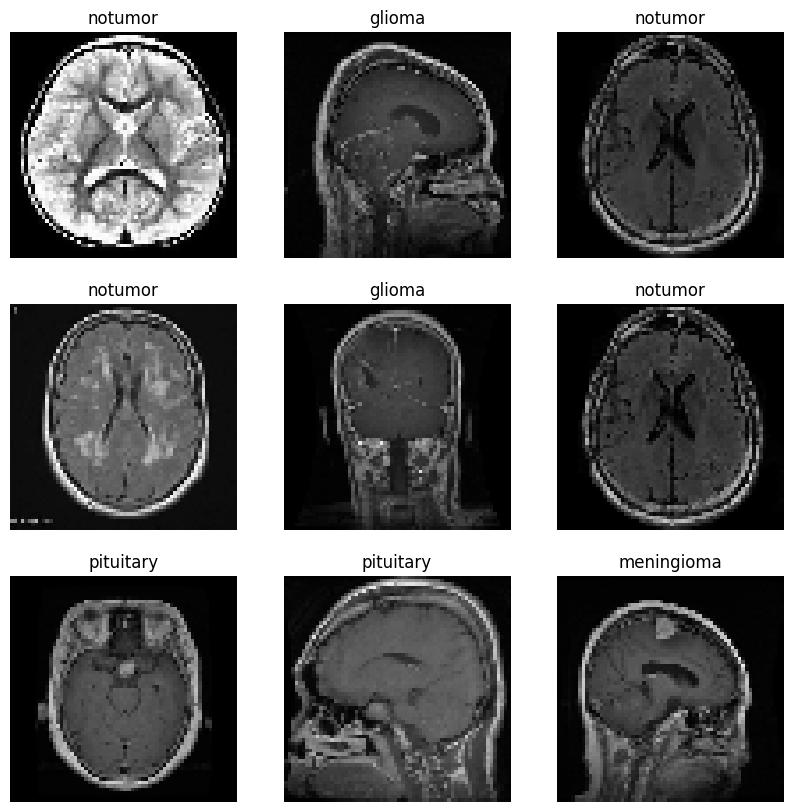

In [ ]:
class_names = train_ds.class_names
print(class_names)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    print(images[i].shape)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
import tensorflow as tf
from tensorflow import keras

preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    tf.keras.layers.Rescaling(1./255),
])

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(1),
    keras.layers.RandomTranslation(0.2, 0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomBrightness(0.2),
    keras.layers.RandomContrast(0.2),
])

train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(None, None, IMAGE_CHANNELS)),

    preprocessing,

    keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),

    # keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    # # keras.layers.BatchNormalization(momentum=0.87),
    # keras.layers.MaxPooling2D(),

    keras.layers.GlobalAveragePooling2D(),

    keras.layers.Dropout(0.4),

    keras.layers.Dense(4, activation="softmax")
])


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

model.summary(
    expand_nested=True,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| resizing (Resizing)       (None, 64, 64, 3)         0         |
|                                                               |
| rescaling (Rescaling)     (None, 64, 64, 3)         0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                    

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

earlystop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[earlystop_loss],
)

Epoch 1/100
143/143 [==============================] - 8s 35ms/step - loss: 0.7969 - sparse_categorical_accuracy: 0.6915 - val_loss: 2.4309 - val_sparse_categorical_accuracy: 0.3958
Epoch 2/100
143/143 [==============================] - 2s 15ms/step - loss: 0.5625 - sparse_categorical_accuracy: 0.7919 - val_loss: 3.3092 - val_sparse_categorical_accuracy: 0.3398
Epoch 3/100
143/143 [==============================] - 2s 15ms/step - loss: 0.4561 - sparse_categorical_accuracy: 0.8280 - val_loss: 1.9134 - val_sparse_categorical_accuracy: 0.6445
Epoch 4/100
143/143 [==============================] - 2s 15ms/step - loss: 0.3795 - sparse_categorical_accuracy: 0.8586 - val_loss: 0.9381 - val_sparse_categorical_accuracy: 0.7119
Epoch 5/100
143/143 [==============================] - 2s 15ms/step - loss: 0.3194 - sparse_categorical_accuracy: 0.8864 - val_loss: 0.3822 - val_sparse_categorical_accuracy: 0.8616
Epoch 6/100
143/143 [==============================] - 2s 15ms/step - loss: 0.2664 - spars

Epochs run: 68


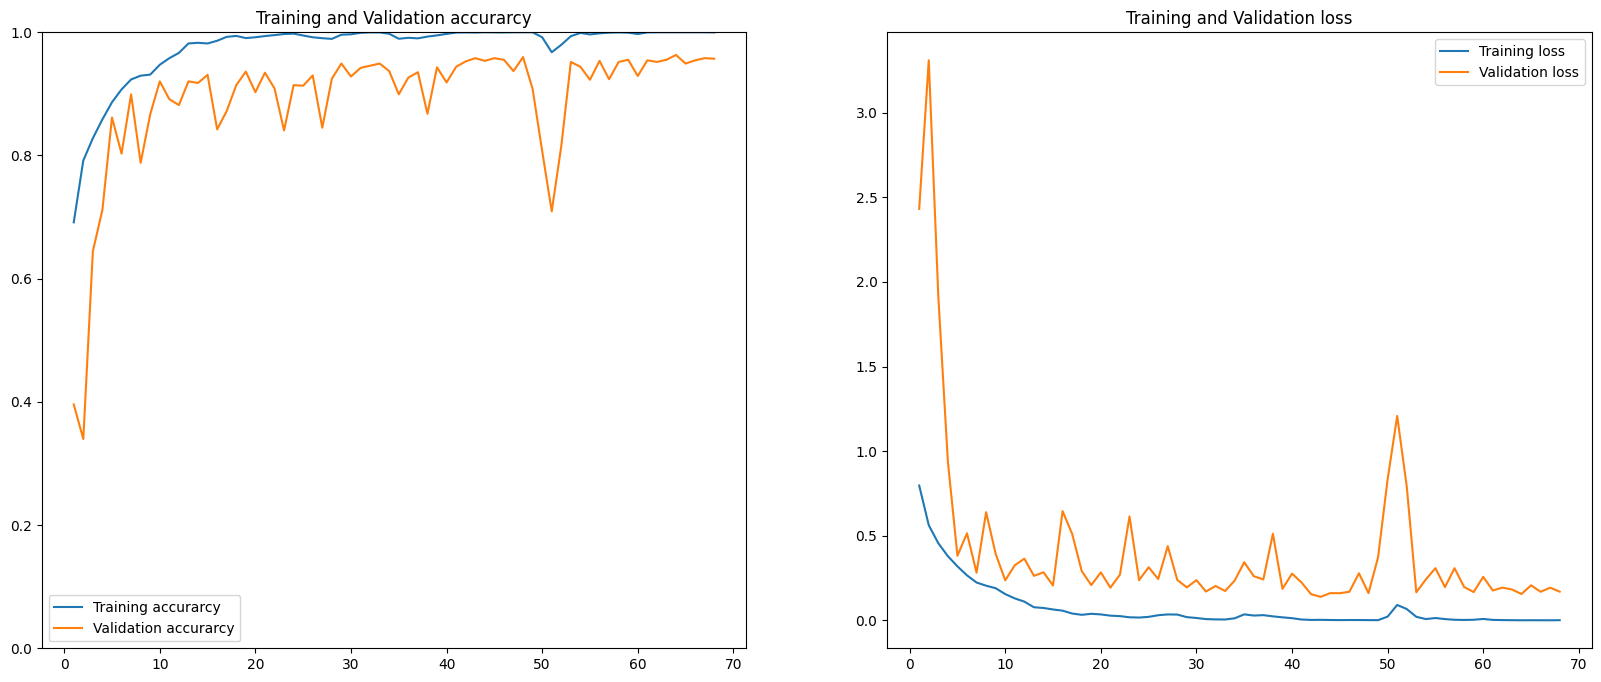

In [ ]:
from matplotlib import pyplot as plt

print("Epochs run:", len(history.history["loss"]))

acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.ylim((0, 1))
plt.plot(epochs, acc, label="Training accurarcy")
plt.plot(epochs, val_acc, label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)

plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(TESTING_FOLER,color_mode=COLOR_MODE,)

results = model.evaluate(test_ds, verbose=0)

print("Test accuracy:", results[1]*100)
print("Test loss:", results[0]*100)

Found 1311 files belonging to 4 classes.
Test accuracy: 96.26239538192749
Test loss: 13.549648225307465


In [ ]:
# SAVING THE MODEL

import pickle

# save the iris classification model
model.save("bt-cnn.h5")

In [ ]:
import tensorflow as tf

model.save("bt-cnn.h5") 
loaded_model = tf.keras.models.load_model("bt-cnn.h5") 
loss, accuracy = loaded_model.evaluate(test_ds) 


41/41 [==============================] - 1s 26ms/step - loss: 0.1355 - sparse_categorical_accuracy: 0.9626
